In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Found GPU at: /device:GPU:0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8911480161168970057
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17155191690690032853
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.889829322999958
GPU (s):
0.10197848100006013
GPU speedup over CPU: 38x


In [3]:
!cat /proc/meminfo

MemTotal:       13302912 kB
MemFree:         5957468 kB
MemAvailable:   11460500 kB
Buffers:          112692 kB
Cached:          4832744 kB
SwapCached:            0 kB
Active:          1871460 kB
Inactive:        5148584 kB
Active(anon):    1318860 kB
Inactive(anon):     3540 kB
Active(file):     552600 kB
Inactive(file):  5145044 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               436 kB
Writeback:             0 kB
AnonPages:       2074628 kB
Mapped:          1469348 kB
Shmem:              4268 kB
KReclaimable:      93936 kB
Slab:             149792 kB
SReclaimable:      93936 kB
SUnreclaim:        55856 kB
KernelStack:        5072 kB
PageTables:        19716 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6651456 kB
Committed_AS:    5173948 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       46764 kB
VmallocChunk:          0 kB
Percpu:          

In [4]:
!pip install wandb

!wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip
!unzip nature_12K.zip
!rm nature_12K.zip

!mv ./inaturalist_12K/val ./inaturalist_12K/test

Streaming output truncated to the last 5000 lines.
  inflating: inaturalist_12K/train/Arachnida/1ac25349af662e85f577a31f64beca41.jpg  
  inflating: inaturalist_12K/train/Arachnida/117ef7f1812725f359500448a258e713.jpg  
  inflating: inaturalist_12K/train/Arachnida/6409254954c3b46d88d64f0bf4c632fa.jpg  
  inflating: inaturalist_12K/train/Arachnida/aaed865750bd52944658a7dd23366948.jpg  
  inflating: inaturalist_12K/train/Arachnida/460cc09ef510d400a4d47a836ddd45e6.jpg  
  inflating: inaturalist_12K/train/Arachnida/55c48c3afef0b745e53951284cdb2db4.jpg  
  inflating: inaturalist_12K/train/Arachnida/bff3daa961ee96a37ebe12dc0bcce504.jpg  
  inflating: inaturalist_12K/train/Arachnida/9082d4f2107bccf1f14d71c8944be607.jpg  
  inflating: inaturalist_12K/train/Arachnida/93d0130423d42f7c6228150eb95a2a93.jpg  
  inflating: inaturalist_12K/train/Arachnida/051aba6d7bc324bad76bd438ed3cc276.jpg  
  inflating: inaturalist_12K/train/Arachnida/67595af09c015c7753d5d4935677590f.jpg  
  inflating: inaturalist_

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#import keras

from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, InputLayer, Flatten, Conv2D, BatchNormalization, MaxPooling2D, Activation , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential,  Model

import wandb

In [7]:
class cnnModel():

    def __init__(self,img_size,model_parameters,num_classes):
        self.num_hidden_cnn_layer = model_parameters["num_hidden_cnn_layer"]
        self.activation = model_parameters["activation"]
        self.batch_normalization = model_parameters["batch_normalization"]
        self.filter_multiplier = model_parameters["filter_multiplier"]
        self.filter_size = model_parameters["filter_size"]
        self.num_filters = model_parameters["num_filters"]
        self.pool_size=model_parameters["pool_size"]
        self.dropout = model_parameters["dropout"]
        self.padding = model_parameters["padding"]
        self.optimizer = model_parameters["optimizer"]
        self.gap = model_parameters["gap"]
        self.batchnorm_location = model_parameters["batchnorm_location"]
        self.dense_neurons = model_parameters["dense_neurons"]
        self.num_classes = num_classes
        self.input_shape = (img_size[0],img_size[1],3)
        self.dropout_loc = model_parameters["dropout_loc"]


    def cnnBlock(self,model,i):
        ## Standard filter distribution - same number of filters in all Convolutional layers
        if self.filter_multiplier == "standard":
            model.add(Conv2D(self.num_filters, self.filter_size,kernel_initializer = "he_uniform",padding = self.padding))
    
        ## Double filter distribution - double number of filters in each Convolutional layers
        elif self.filter_multiplier == "double":
            model.add(Conv2D(2**(i+1)*self.num_filters, self.filter_size,kernel_initializer = "he_uniform", padding = self.padding))
    
        ## Halve the filter size in each successive convolutional layers
        elif self.filter_multiplier == "half":
            model.add(Conv2D(int(self.num_filters/2**(i+1)), self.filter_size,kernel_initializer = "he_uniform", padding = self.padding))
    
        if self.batchnorm_location == "Before" and self.batch_normalization: model.add(BatchNormalization())
        model.add(Activation(self.activation))
    
        if self.batchnorm_location == "After" and self.batch_normalization: model.add(BatchNormalization())
    
        model.add(MaxPooling2D(pool_size=self.pool_size))

        return model
        

    def build_cnnmodel(self):
        with tf.device('/device:GPU:0'):
            tf.keras.backend.clear_session()
            model = Sequential()
            
            #First CNN layer connecting to input layer
            model.add(Conv2D(self.num_filters, self.filter_size, padding = self.padding,kernel_initializer = "he_uniform", input_shape = self.input_shape))
            if self.batchnorm_location == "Before" and self.batch_normalization: model.add(BatchNormalization())
            model.add(Activation(self.activation))
            if self.batchnorm_location == "After" and self.batch_normalization: model.add(BatchNormalization())
            model.add(MaxPooling2D(pool_size=self.pool_size))  
             
            if self.dropout_loc == "conv" or self.dropout_loc=="all":
                if self.dropout != None:
                    model.add(tf.keras.layers.Dropout(self.dropout))
                for i in range(self.num_hidden_cnn_layer-1):
                    model = self.cnnBlock(model,i)
                    if self.dropout != None:
                        model.add(tf.keras.layers.Dropout(self.dropout))

            elif self.dropout_loc == "dense":
                for i in range(self.num_hidden_cnn_layer-1):
                    model = self.cnnBlock(model,i)

            
            #Final densely connected layers
            if self.gap == True:
                model.add(GlobalAveragePooling2D())
            else: 
                model.add(Flatten())

            if self.dropout_loc == "dense" or self.dropout_loc =="all":
                model.add(Dense(self.dense_neurons, activation = 'sigmoid'))
                if self.dropout != None:
                    model.add(tf.keras.layers.Dropout(self.dropout))
                model.add(Dense(self.num_classes, activation = 'softmax'))

            elif self.dropout_loc =="conv":
                model.add(Dense(self.dense_neurons, activation = 'sigmoid'))
                model.add(Dense(self.num_classes, activation = 'softmax'))

            return model



In [17]:
# data preprocessing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import pathlib

#wandb logging
import wandb
from wandb.keras import WandbCallback

img_size = (128,128)


#sweep config
sweep_config = {
  "name": "Bayesian Sweep",
  "method": "bayes",
  "metric":{
  "name": "val_accuracy",
  "goal": "maximize"
  },
  "parameters": {
        
        "activation":{
            "values": ["relu", "elu", "selu"]
        },
        "filter_size": {
            "values": [(2,2), (3,3), (4,4)]
        },
        "batch_size": {
            "values": [32, 64]
        },
        "padding": {
            "values": ["same","valid"]
        },
        "data_augmentation": {
            "values": [True, False]
        },
        "optimizer": {
            "values": ["sgd", "adam", "rmsprop", "nadam"]
        },
        "batch_normalization": {
            "values": [True, False]
        },
        "batchnorm_location": {
            "values": ["Before", "After"]
        },
        "num_filters": {
            "values": [32, 64]
        },
        "dense_neurons": {
            "values": [32, 64, 128]
        },   
        "dropout_loc": {
            "values": ["conv","dense","all"]
        },
        "dropout": {
            "values": [None, 0.2,0.3]
        },  
        "gap": {
            "values": [False,True]
        },        
    }
}

sweep_id = wandb.sweep(sweep_config,project='CS6910-Assignment2-PartA', entity='cs21m007_cs21m013')



#train function
def train():

        
    config_defaults = dict(
            num_hidden_cnn_layer = 5 ,
            activation = 'relu',
            batch_normalization = True,
            batchnorm_location = "After",
            filter_multiplier = "double" ,
            filter_size = (3,3),
            num_filters  = 32,
            dropout = None,
            dropout_loc = "dense",
            pool_size = (2,2),
            padding = 'same',
            dense_neurons = 128,
            num_classes = 10,
            optimizer = 'adam',
            epochs = 5,
            batch_size = 32, 
            data_augmentation = False,
            gap = True,
            img_size = img_size
        ) 



    #wandb.init( config = config_defaults)
    wandb.init(project = 'CS6910-Assignment2-PartA', config = config_defaults,entity='cs21m007_cs21m013')
    CONFIG = wandb.config


    wandb.run.name = "Image_recog" + str(CONFIG.num_hidden_cnn_layer) + "_dn_" + str(CONFIG.dense_neurons) + "_opt_" + CONFIG.optimizer + "_dro_" + str(CONFIG.dropout) + "_bs_"+str(CONFIG.batch_size) + "_fm_" + CONFIG.filter_multiplier + "_bnl_" + CONFIG.batchnorm_location + "_dpl_" + CONFIG.dropout_loc

    data_augmentation = CONFIG.data_augmentation

    
    BATCH_SIZE = CONFIG.batch_size


    if data_augmentation == True:

    #Faster Alternative
        train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255,
                validation_split = 0.1,
                shear_range=0.2,
                zoom_range=0.2,
                rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=True,  # randomly flip images
                vertical_flip=False
                )
    else:
        train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split = 0.1)

    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


    train_generator = train_datagen.flow_from_directory(
        './inaturalist_12K/train',
        subset='training',
        target_size=img_size,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle = True,
        seed = 123)
        
    validation_generator = train_datagen.flow_from_directory(
            './inaturalist_12K/train',
            target_size=img_size,
            subset = 'validation',
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle = True,
            seed = 123)


            
    test_generator = test_datagen.flow_from_directory(
            './inaturalist_12K/test',
            target_size=img_size,
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle = True,
            seed = 123)



    with tf.device('/device:GPU:0'):        
        objDetn = cnnModel(CONFIG.img_size, CONFIG, 10)
        model = objDetn.build_cnnmodel()
        
        model.summary()



        model.compile(
        optimizer=CONFIG.optimizer,  # Optimizer
        # Loss function to minimize
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),#'categorical_crossentropy',
        # List of metrics to monitor
        metrics=['accuracy'],
        )
      
        history = model.fit(
                        train_generator,
                        steps_per_epoch = train_generator.samples // CONFIG.batch_size,
                        validation_data = validation_generator, 
                        validation_steps = validation_generator.samples // CONFIG.batch_size,
                        epochs = CONFIG.epochs, 
                        callbacks=[WandbCallback()]
                        )

        model.save('./TrainedModel/'+wandb.run.name)
        wandb.finish()
        return model, history

Create sweep with ID: lhjkfpae
Sweep URL: https://wandb.ai/cs21m007_cs21m013/CS6910-Assignment2-PartA/sweeps/lhjkfpae


In [ ]:
wandb.agent(sweep_id, train, count = 30)

wandb: Agent Starting Run: br1pol3q with config:
wandb: 	activation: elu
wandb: 	batch_normalization: False
wandb: 	batch_size: 64
wandb: 	batchnorm_location: After
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 32
wandb: 	dropout: None
wandb: 	dropout_loc: all
wandb: 	filter_size: [2, 2]
wandb: 	gap: False
wandb: 	num_filters: 64
wandb: 	optimizer: nadam
wandb: 	padding: valid
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 4000 images belonging to 11 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 127, 64)      832       
                                                                 
 activation (Activation)     (None, 127, 127, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 128)       32896     
                                                                 
 activation_1 (Activation)   (None, 62, 62, 128)       0         
                                                            

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


140/140 [==============================] - 165s 1s/step - loss: 2.3521 - accuracy: 0.1003 - val_loss: 2.3070 - val_accuracy: 0.1000 - _timestamp: 1648351819.0000 - _runtime: 179.0000
Epoch 2/5
140/140 [==============================] - 137s 976ms/step - loss: 2.3067 - accuracy: 0.1012 - val_loss: 2.3034 - val_accuracy: 0.0969 - _timestamp: 1648351995.0000 - _runtime: 355.0000
Epoch 3/5
140/140 [==============================] - 135s 966ms/step - loss: 2.3041 - accuracy: 0.0949 - val_loss: 2.3033 - val_accuracy: 0.1021 - _timestamp: 1648352130.0000 - _runtime: 490.0000
Epoch 4/5
140/140 [==============================] - 135s 965ms/step - loss: 2.3057 - accuracy: 0.0899 - val_loss: 2.3030 - val_accuracy: 0.1000 - _timestamp: 1648352272.0000 - _runtime: 632.0000
Epoch 5/5
140/140 [==============================] - 135s 961ms/step - loss: 2.3040 - accuracy: 0.0919 - val_loss: 2.3030 - val_accuracy: 0.0990 - _timestamp: 1648352406.0000 - _runtime: 766.0000
INFO:tensorflow:Assets written to

accuracy,▇█▄▁▂
epoch,▁▃▅▆█
loss,█▁▁▁▁
val_accuracy,▅▁█▅▄
val_loss,█▂▂▁▁
accuracy,0.09188
best_epoch,4
best_val_loss,2.30297
epoch,4
loss,2.304
val_accuracy,0.09896


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rpzivefn with config:
wandb: 	activation: selu
wandb: 	batch_normalization: False
wandb: 	batch_size: 64
wandb: 	batchnorm_location: Before
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 64
wandb: 	dropout: None
wandb: 	dropout_loc: conv
wandb: 	filter_size: [3, 3]
wandb: 	gap: False
wandb: 	num_filters: 32
wandb: 	optimizer: rmsprop
wandb: 	padding: same
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 4000 images belonging to 11 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 activation (Activation)     (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 64, 64, 64)        0         
                                                            

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


140/140 [==============================] - 106s 741ms/step - loss: 2.3658 - accuracy: 0.0993 - val_loss: 2.3054 - val_accuracy: 0.1010 - _timestamp: 1648352556.0000 - _runtime: 113.0000
Epoch 2/5
140/140 [==============================] - 103s 736ms/step - loss: 2.3056 - accuracy: 0.1050 - val_loss: 2.3056 - val_accuracy: 0.1010 - _timestamp: 1648352696.0000 - _runtime: 253.0000
Epoch 3/5
140/140 [==============================] - 103s 738ms/step - loss: 2.3058 - accuracy: 0.1006 - val_loss: 2.3052 - val_accuracy: 0.1021 - _timestamp: 1648352800.0000 - _runtime: 357.0000
Epoch 4/5
140/140 [==============================] - 103s 736ms/step - loss: 2.3061 - accuracy: 0.0980 - val_loss: 2.3038 - val_accuracy: 0.1010 - _timestamp: 1648352903.0000 - _runtime: 460.0000
Epoch 5/5
140/140 [==============================] - 103s 737ms/step - loss: 2.3056 - accuracy: 0.0988 - val_loss: 2.3052 - val_accuracy: 0.1021 - _timestamp: 1648353045.0000 - _runtime: 602.0000
INFO:tensorflow:Assets written

accuracy,▂█▄▁▂
epoch,▁▃▅▆█
loss,█▁▁▁▁
val_accuracy,▁▁█▁█
val_loss,▇█▆▁▇
accuracy,0.09881
best_epoch,3
best_val_loss,2.30377
epoch,4
loss,2.30564
val_accuracy,0.10208


wandb: Agent Starting Run: 0b4g0iwi with config:
wandb: 	activation: elu
wandb: 	batch_normalization: True
wandb: 	batch_size: 64
wandb: 	batchnorm_location: After
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	dropout_loc: all
wandb: 	filter_size: [3, 3]
wandb: 	gap: True
wandb: 	num_filters: 32
wandb: 	optimizer: sgd
wandb: 	padding: valid
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 4000 images belonging to 11 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 activation (Activation)     (None, 126, 126, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


140/140 [==============================] - 135s 953ms/step - loss: 2.3518 - accuracy: 0.1395 - val_loss: 2.5024 - val_accuracy: 0.1083 - _timestamp: 1648353201.0000 - _runtime: 143.0000
Epoch 2/5
140/140 [==============================] - 133s 950ms/step - loss: 2.2283 - accuracy: 0.1880 - val_loss: 2.5371 - val_accuracy: 0.1021 - _timestamp: 1648353334.0000 - _runtime: 276.0000
Epoch 3/5
140/140 [==============================] - 133s 951ms/step - loss: 2.1863 - accuracy: 0.2108 - val_loss: 2.4755 - val_accuracy: 0.1156 - _timestamp: 1648353467.0000 - _runtime: 409.0000
Epoch 4/5
140/140 [==============================] - 133s 950ms/step - loss: 2.1558 - accuracy: 0.2193 - val_loss: 2.4479 - val_accuracy: 0.1354 - _timestamp: 1648353600.0000 - _runtime: 542.0000
Epoch 5/5
140/140 [==============================] - 133s 950ms/step - loss: 2.1319 - accuracy: 0.2304 - val_loss: 2.4106 - val_accuracy: 0.1542 - _timestamp: 1648353742.0000 - _runtime: 684.0000
INFO:tensorflow:Assets written

accuracy,▁▅▆▇█
epoch,▁▃▅▆█
loss,█▄▃▂▁
val_accuracy,▂▁▃▅█
val_loss,▆█▅▃▁
accuracy,0.23042
best_epoch,4
best_val_loss,2.41057
epoch,4
loss,2.13191
val_accuracy,0.15417


wandb: Agent Starting Run: v7535ak6 with config:
wandb: 	activation: relu
wandb: 	batch_normalization: False
wandb: 	batch_size: 64
wandb: 	batchnorm_location: After
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 64
wandb: 	dropout: 0.3
wandb: 	dropout_loc: all
wandb: 	filter_size: [4, 4]
wandb: 	gap: True
wandb: 	num_filters: 32
wandb: 	optimizer: adam
wandb: 	padding: valid
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 4000 images belonging to 11 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 32)      1568      
                                                                 
 activation (Activation)     (None, 125, 125, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 62, 62, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 64)        32832     
                                                            

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


140/140 [==============================] - 105s 741ms/step - loss: 2.4519 - accuracy: 0.0956 - val_loss: 2.3095 - val_accuracy: 0.1010 - _timestamp: 1648353874.0000 - _runtime: 113.0000
Epoch 2/5
140/140 [==============================] - 104s 742ms/step - loss: 2.4032 - accuracy: 0.1016 - val_loss: 2.3079 - val_accuracy: 0.1000 - _timestamp: 1648353977.0000 - _runtime: 216.0000
Epoch 3/5
140/140 [==============================] - 104s 740ms/step - loss: 2.3808 - accuracy: 0.0985 - val_loss: 2.3035 - val_accuracy: 0.0979 - _timestamp: 1648354081.0000 - _runtime: 320.0000
Epoch 4/5
140/140 [==============================] - 103s 739ms/step - loss: 2.3660 - accuracy: 0.0997 - val_loss: 2.3143 - val_accuracy: 0.0990 - _timestamp: 1648354223.0000 - _runtime: 462.0000
Epoch 5/5
140/140 [==============================] - 113s 808ms/step - loss: 2.3494 - accuracy: 0.0941 - val_loss: 2.3073 - val_accuracy: 0.0958 - _timestamp: 1648354336.0000 - _runtime: 575.0000
INFO:tensorflow:Assets written

accuracy,▂█▅▆▁
epoch,▁▃▅▆█
loss,█▅▃▂▁
val_accuracy,█▇▄▅▁
val_loss,▅▄▁█▃
accuracy,0.09411
best_epoch,2
best_val_loss,2.30346
epoch,4
loss,2.34944
val_accuracy,0.09583


wandb: Agent Starting Run: lwuor1w9 with config:
wandb: 	activation: elu
wandb: 	batch_normalization: False
wandb: 	batch_size: 32
wandb: 	batchnorm_location: Before
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 64
wandb: 	dropout: 0.3
wandb: 	dropout_loc: dense
wandb: 	filter_size: [3, 3]
wandb: 	gap: False
wandb: 	num_filters: 32
wandb: 	optimizer: nadam
wandb: 	padding: valid
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 4000 images belonging to 11 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 activation (Activation)     (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 61, 61, 64)        0         
                                                            

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


281/281 [==============================] - 144s 506ms/step - loss: 2.4114 - accuracy: 0.1029 - val_loss: 2.3052 - val_accuracy: 0.0998 - _timestamp: 1648354528.0000 - _runtime: 151.0000
Epoch 2/5
281/281 [==============================] - 142s 505ms/step - loss: 2.3902 - accuracy: 0.1025 - val_loss: 2.3049 - val_accuracy: 0.0998 - _timestamp: 1648354729.0000 - _runtime: 352.0000
Epoch 3/5
281/281 [==============================] - 135s 481ms/step - loss: 2.3763 - accuracy: 0.0978 - val_loss: 2.3092 - val_accuracy: 0.0978 - _timestamp: 1648354865.0000 - _runtime: 488.0000
Epoch 4/5
281/281 [==============================] - 134s 478ms/step - loss: 2.3567 - accuracy: 0.0959 - val_loss: 2.3067 - val_accuracy: 0.1008 - _timestamp: 1648355006.0000 - _runtime: 629.0000
Epoch 5/5
281/281 [==============================] - 134s 478ms/step - loss: 2.3313 - accuracy: 0.0991 - val_loss: 2.3057 - val_accuracy: 0.1008 - _timestamp: 1648355148.0000 - _runtime: 771.0000
INFO:tensorflow:Assets written

accuracy,██▃▁▄
epoch,▁▃▅▆█
loss,█▆▅▃▁
val_accuracy,▆▆▁██
val_loss,▂▁█▄▂
accuracy,0.09913
best_epoch,1
best_val_loss,2.30491
epoch,4
loss,2.33134
val_accuracy,0.10081


wandb: Agent Starting Run: lv1sl4ex with config:
wandb: 	activation: elu
wandb: 	batch_normalization: True
wandb: 	batch_size: 64
wandb: 	batchnorm_location: Before
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 64
wandb: 	dropout: 0.3
wandb: 	dropout_loc: conv
wandb: 	filter_size: [2, 2]
wandb: 	gap: True
wandb: 	num_filters: 64
wandb: 	optimizer: rmsprop
wandb: 	padding: valid
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 4000 images belonging to 11 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 127, 64)      832       
                                                                 
 batch_normalization (BatchN  (None, 127, 127, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 127, 127, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 64)        0    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


140/140 [==============================] - 109s 768ms/step - loss: 2.1260 - accuracy: 0.2332 - val_loss: 2.3875 - val_accuracy: 0.1187 - _timestamp: 1648355285.0000 - _runtime: 117.0000
Epoch 2/5
140/140 [==============================] - 107s 761ms/step - loss: 2.0303 - accuracy: 0.2765 - val_loss: 2.2646 - val_accuracy: 0.1896 - _timestamp: 1648355426.0000 - _runtime: 258.0000
Epoch 3/5
140/140 [==============================] - 107s 762ms/step - loss: 1.9735 - accuracy: 0.2995 - val_loss: 2.0619 - val_accuracy: 0.2656 - _timestamp: 1648355568.0000 - _runtime: 400.0000
Epoch 4/5
140/140 [==============================] - 106s 759ms/step - loss: 1.9326 - accuracy: 0.3141 - val_loss: 2.2251 - val_accuracy: 0.1875 - _timestamp: 1648355675.0000 - _runtime: 507.0000
Epoch 5/5
140/140 [==============================] - 106s 756ms/step - loss: 1.9043 - accuracy: 0.3292 - val_loss: 2.0125 - val_accuracy: 0.2937 - _timestamp: 1648355780.0000 - _runtime: 612.0000
INFO:tensorflow:Assets written

accuracy,▁▄▆▇█
epoch,▁▃▅▆█
loss,█▅▃▂▁
val_accuracy,▁▄▇▄█
val_loss,█▆▂▅▁
accuracy,0.32923
best_epoch,4
best_val_loss,2.01246
epoch,4
loss,1.90432
val_accuracy,0.29375


wandb: Agent Starting Run: v5oetm31 with config:
wandb: 	activation: relu
wandb: 	batch_normalization: True
wandb: 	batch_size: 32
wandb: 	batchnorm_location: Before
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	dropout_loc: dense
wandb: 	filter_size: [4, 4]
wandb: 	gap: True
wandb: 	num_filters: 64
wandb: 	optimizer: sgd
wandb: 	padding: valid
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 4000 images belonging to 11 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 64)      3136      
                                                                 
 batch_normalization (BatchN  (None, 125, 125, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 125, 125, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 128)       13120

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


281/281 [==============================] - 112s 393ms/step - loss: 2.1341 - accuracy: 0.2366 - val_loss: 2.1118 - val_accuracy: 0.2409 - _timestamp: 1648355950.0000 - _runtime: 119.0000
Epoch 2/5
281/281 [==============================] - 110s 390ms/step - loss: 1.9294 - accuracy: 0.3175 - val_loss: 1.9500 - val_accuracy: 0.3286 - _timestamp: 1648356090.0000 - _runtime: 259.0000
Epoch 3/5
281/281 [==============================] - 120s 425ms/step - loss: 1.8249 - accuracy: 0.3676 - val_loss: 1.9385 - val_accuracy: 0.3296 - _timestamp: 1648356242.0000 - _runtime: 411.0000
Epoch 4/5
281/281 [==============================] - 109s 389ms/step - loss: 1.7182 - accuracy: 0.4173 - val_loss: 1.9538 - val_accuracy: 0.3387 - _timestamp: 1648356352.0000 - _runtime: 521.0000
Epoch 5/5
281/281 [==============================] - 110s 391ms/step - loss: 1.6017 - accuracy: 0.4642 - val_loss: 1.8944 - val_accuracy: 0.3518 - _timestamp: 1648356494.0000 - _runtime: 663.0000
INFO:tensorflow:Assets written

accuracy,▁▃▅▇█
epoch,▁▃▅▆█
loss,█▅▄▃▁
val_accuracy,▁▇▇▇█
val_loss,█▃▂▃▁
accuracy,0.46421
best_epoch,4
best_val_loss,1.89437
epoch,4
loss,1.6017
val_accuracy,0.35181


wandb: Agent Starting Run: c9tgc22z with config:
wandb: 	activation: elu
wandb: 	batch_normalization: True
wandb: 	batch_size: 64
wandb: 	batchnorm_location: Before
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	dropout_loc: dense
wandb: 	filter_size: [4, 4]
wandb: 	gap: True
wandb: 	num_filters: 64
wandb: 	optimizer: sgd
wandb: 	padding: valid
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 4000 images belonging to 11 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 64)      3136      
                                                                 
 batch_normalization (BatchN  (None, 125, 125, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 125, 125, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 128)       13120

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


140/140 [==============================] - 110s 770ms/step - loss: 2.1616 - accuracy: 0.2299 - val_loss: 2.1717 - val_accuracy: 0.2156 - _timestamp: 1648356658.0000 - _runtime: 118.0000
Epoch 2/5
140/140 [==============================] - 107s 766ms/step - loss: 2.0011 - accuracy: 0.2951 - val_loss: 2.0548 - val_accuracy: 0.2646 - _timestamp: 1648356766.0000 - _runtime: 226.0000
Epoch 3/5
140/140 [==============================] - 106s 760ms/step - loss: 1.9027 - accuracy: 0.3393 - val_loss: 1.9585 - val_accuracy: 0.3292 - _timestamp: 1648356872.0000 - _runtime: 332.0000
Epoch 4/5
140/140 [==============================] - 107s 763ms/step - loss: 1.8296 - accuracy: 0.3677 - val_loss: 1.9301 - val_accuracy: 0.3344 - _timestamp: 1648356979.0000 - _runtime: 439.0000
Epoch 5/5
140/140 [==============================] - 107s 764ms/step - loss: 1.7554 - accuracy: 0.3981 - val_loss: 1.9069 - val_accuracy: 0.3438 - _timestamp: 1648357121.0000 - _runtime: 581.0000
INFO:tensorflow:Assets written

accuracy,▁▄▆▇█
epoch,▁▃▅▆█
loss,█▅▄▂▁
val_accuracy,▁▄▇▇█
val_loss,█▅▂▂▁
accuracy,0.39805
best_epoch,4
best_val_loss,1.90688
epoch,4
loss,1.75541
val_accuracy,0.34375


wandb: Agent Starting Run: m8k0zm8o with config:
wandb: 	activation: relu
wandb: 	batch_normalization: True
wandb: 	batch_size: 64
wandb: 	batchnorm_location: Before
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	dropout_loc: dense
wandb: 	filter_size: [2, 2]
wandb: 	gap: True
wandb: 	num_filters: 64
wandb: 	optimizer: adam
wandb: 	padding: same
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 4000 images belonging to 11 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      832       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       32896

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


140/140 [==============================] - 110s 767ms/step - loss: 2.1150 - accuracy: 0.2466 - val_loss: 2.3924 - val_accuracy: 0.1573 - _timestamp: 1648357290.0000 - _runtime: 118.0000
Epoch 2/5
140/140 [==============================] - 106s 760ms/step - loss: 1.9886 - accuracy: 0.2910 - val_loss: 2.6142 - val_accuracy: 0.1708 - _timestamp: 1648357429.0000 - _runtime: 257.0000
Epoch 3/5
140/140 [==============================] - 106s 758ms/step - loss: 1.9190 - accuracy: 0.3197 - val_loss: 2.0343 - val_accuracy: 0.2885 - _timestamp: 1648357535.0000 - _runtime: 363.0000
Epoch 4/5
140/140 [==============================] - 106s 756ms/step - loss: 1.8609 - accuracy: 0.3430 - val_loss: 2.0894 - val_accuracy: 0.2729 - _timestamp: 1648357641.0000 - _runtime: 469.0000
Epoch 5/5
140/140 [==============================] - 106s 759ms/step - loss: 1.8083 - accuracy: 0.3637 - val_loss: 1.9952 - val_accuracy: 0.3198 - _timestamp: 1648357748.0000 - _runtime: 576.0000
INFO:tensorflow:Assets written

accuracy,▁▄▅▇█
epoch,▁▃▅▆█
loss,█▅▄▂▁
val_accuracy,▁▂▇▆█
val_loss,▅█▁▂▁
accuracy,0.3637
best_epoch,4
best_val_loss,1.99519
epoch,4
loss,1.80828
val_accuracy,0.31979


wandb: Agent Starting Run: gdu2ncvd with config:
wandb: 	activation: relu
wandb: 	batch_normalization: True
wandb: 	batch_size: 64
wandb: 	batchnorm_location: Before
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	dropout_loc: conv
wandb: 	filter_size: [4, 4]
wandb: 	gap: True
wandb: 	num_filters: 64
wandb: 	optimizer: sgd
wandb: 	padding: valid
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 4000 images belonging to 11 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 64)      3136      
                                                                 
 batch_normalization (BatchN  (None, 125, 125, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 125, 125, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 62, 62, 64)        0    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


140/140 [==============================] - 109s 770ms/step - loss: 2.2797 - accuracy: 0.1524 - val_loss: 2.3777 - val_accuracy: 0.1156 - _timestamp: 1648357915.0000 - _runtime: 117.0000
Epoch 2/5
140/140 [==============================] - 107s 764ms/step - loss: 2.1658 - accuracy: 0.2172 - val_loss: 2.3766 - val_accuracy: 0.1198 - _timestamp: 1648358022.0000 - _runtime: 224.0000
Epoch 3/5
140/140 [==============================] - 107s 762ms/step - loss: 2.1124 - accuracy: 0.2437 - val_loss: 2.3325 - val_accuracy: 0.1552 - _timestamp: 1648358164.0000 - _runtime: 366.0000
Epoch 4/5
140/140 [==============================] - 107s 763ms/step - loss: 2.0711 - accuracy: 0.2626 - val_loss: 2.3172 - val_accuracy: 0.1302 - _timestamp: 1648358271.0000 - _runtime: 473.0000
Epoch 5/5
140/140 [==============================] - 107s 761ms/step - loss: 2.0477 - accuracy: 0.2719 - val_loss: 2.3431 - val_accuracy: 0.1281 - _timestamp: 1648358377.0000 - _runtime: 579.0000
INFO:tensorflow:Assets written

accuracy,▁▅▆▇█
epoch,▁▃▅▆█
loss,█▅▃▂▁
val_accuracy,▁▂█▄▃
val_loss,██▃▁▄
accuracy,0.27193
best_epoch,3
best_val_loss,2.31718
epoch,4
loss,2.04769
val_accuracy,0.12812


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qidbllwd with config:
wandb: 	activation: elu
wandb: 	batch_normalization: False
wandb: 	batch_size: 64
wandb: 	batchnorm_location: After
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	dropout_loc: dense
wandb: 	filter_size: [3, 3]
wandb: 	gap: True
wandb: 	num_filters: 64
wandb: 	optimizer: sgd
wandb: 	padding: valid
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 4000 images belonging to 11 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 activation (Activation)     (None, 126, 126, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       73856     
                                                                 
 activation_1 (Activation)   (None, 61, 61, 128)       0         
                                                            

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


140/140 [==============================] - 108s 757ms/step - loss: 2.3035 - accuracy: 0.1416 - val_loss: 2.1923 - val_accuracy: 0.2094 - _timestamp: 1648358562.0000 - _runtime: 117.0000
Epoch 2/5
140/140 [==============================] - 105s 749ms/step - loss: 2.1984 - accuracy: 0.1910 - val_loss: 2.1206 - val_accuracy: 0.2250 - _timestamp: 1648358667.0000 - _runtime: 222.0000
Epoch 3/5
140/140 [==============================] - 105s 748ms/step - loss: 2.1475 - accuracy: 0.2221 - val_loss: 2.1004 - val_accuracy: 0.2406 - _timestamp: 1648358772.0000 - _runtime: 327.0000
Epoch 4/5
140/140 [==============================] - 104s 746ms/step - loss: 2.1155 - accuracy: 0.2353 - val_loss: 2.1252 - val_accuracy: 0.2427 - _timestamp: 1648358876.0000 - _runtime: 431.0000
Epoch 5/5
140/140 [==============================] - 105s 749ms/step - loss: 2.0908 - accuracy: 0.2481 - val_loss: 2.0512 - val_accuracy: 0.2906 - _timestamp: 1648358981.0000 - _runtime: 536.0000
INFO:tensorflow:Assets written

accuracy,▁▄▆▇█
epoch,▁▃▅▆█
loss,█▅▃▂▁
val_accuracy,▁▂▄▄█
val_loss,█▄▃▅▁
accuracy,0.2481
best_epoch,4
best_val_loss,2.05116
epoch,4
loss,2.09077
val_accuracy,0.29063


wandb: Agent Starting Run: pttw9fs9 with config:
wandb: 	activation: elu
wandb: 	batch_normalization: False
wandb: 	batch_size: 64
wandb: 	batchnorm_location: Before
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 64
wandb: 	dropout: None
wandb: 	dropout_loc: all
wandb: 	filter_size: [4, 4]
wandb: 	gap: True
wandb: 	num_filters: 32
wandb: 	optimizer: nadam
wandb: 	padding: valid
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 4000 images belonging to 11 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 32)      1568      
                                                                 
 activation (Activation)     (None, 125, 125, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 64)        32832     
                                                                 
 activation_1 (Activation)   (None, 59, 59, 64)        0         
                                                            

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


140/140 [==============================] - 105s 745ms/step - loss: 2.3214 - accuracy: 0.1011 - val_loss: 2.3164 - val_accuracy: 0.1000 - _timestamp: 1648359110.0000 - _runtime: 114.0000
Epoch 2/5
140/140 [==============================] - 104s 742ms/step - loss: 2.3211 - accuracy: 0.0949 - val_loss: 2.3042 - val_accuracy: 0.1010 - _timestamp: 1648359251.0000 - _runtime: 255.0000
Epoch 3/5
140/140 [==============================] - 103s 739ms/step - loss: 2.3057 - accuracy: 0.0941 - val_loss: 2.3047 - val_accuracy: 0.1000 - _timestamp: 1648359355.0000 - _runtime: 359.0000
Epoch 4/5
140/140 [==============================] - 104s 740ms/step - loss: 2.3058 - accuracy: 0.0971 - val_loss: 2.3031 - val_accuracy: 0.1010 - _timestamp: 1648359497.0000 - _runtime: 501.0000
Epoch 5/5
140/140 [==============================] - 103s 739ms/step - loss: 2.3050 - accuracy: 0.0958 - val_loss: 2.3069 - val_accuracy: 0.0958 - _timestamp: 1648359639.0000 - _runtime: 643.0000
INFO:tensorflow:Assets written

accuracy,█▂▁▄▃
epoch,▁▃▅▆█
loss,██▁▁▁
val_accuracy,▇█▇█▁
val_loss,█▂▂▁▃
accuracy,0.09579
best_epoch,3
best_val_loss,2.30308
epoch,4
loss,2.30501
val_accuracy,0.09583


wandb: Agent Starting Run: 0fss5k0c with config:
wandb: 	activation: elu
wandb: 	batch_normalization: False
wandb: 	batch_size: 64
wandb: 	batchnorm_location: Before
wandb: 	data_augmentation: True
wandb: 	dense_neurons: 32
wandb: 	dropout: None
wandb: 	dropout_loc: conv
wandb: 	filter_size: [2, 2]
wandb: 	gap: True
wandb: 	num_filters: 64
wandb: 	optimizer: rmsprop
wandb: 	padding: same
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 4000 images belonging to 11 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      832       
                                                                 
 activation (Activation)     (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       32896     
                                                                 
 activation_1 (Activation)   (None, 64, 64, 128)       0         
                                                            

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


140/140 [==============================] - 137s 973ms/step - loss: 2.3302 - accuracy: 0.0979 - val_loss: 2.3036 - val_accuracy: 0.1021 - _timestamp: 1648359799.0000 - _runtime: 146.0000
Epoch 2/5
140/140 [==============================] - 136s 968ms/step - loss: 2.3039 - accuracy: 0.1011 - val_loss: 2.3032 - val_accuracy: 0.1010 - _timestamp: 1648359935.0000 - _runtime: 282.0000
Epoch 3/5
140/140 [==============================] - 135s 967ms/step - loss: 2.3039 - accuracy: 0.1037 - val_loss: 2.3035 - val_accuracy: 0.0979 - _timestamp: 1648360070.0000 - _runtime: 417.0000
Epoch 4/5
140/140 [==============================] - 136s 969ms/step - loss: 2.3082 - accuracy: 0.0994 - val_loss: 2.3033 - val_accuracy: 0.1000 - _timestamp: 1648360212.0000 - _runtime: 559.0000
Epoch 5/5
140/140 [==============================] - 136s 968ms/step - loss: 2.3064 - accuracy: 0.0984 - val_loss: 2.3033 - val_accuracy: 0.0990 - _timestamp: 1648360348.0000 - _runtime: 695.0000
INFO:tensorflow:Assets written

accuracy,▁▅█▃▂
epoch,▁▃▅▆█
loss,█▁▁▂▂
val_accuracy,█▆▁▅▃
val_loss,█▁▅▂▂
accuracy,0.09837
best_epoch,1
best_val_loss,2.30324
epoch,4
loss,2.30641
val_accuracy,0.09896


wandb: Agent Starting Run: kfctuqqg with config:
wandb: 	activation: elu
wandb: 	batch_normalization: False
wandb: 	batch_size: 64
wandb: 	batchnorm_location: Before
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	dropout_loc: dense
wandb: 	filter_size: [4, 4]
wandb: 	gap: True
wandb: 	num_filters: 64
wandb: 	optimizer: sgd
wandb: 	padding: valid
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 4000 images belonging to 11 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 64)      3136      
                                                                 
 activation (Activation)     (None, 125, 125, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 128)       131200    
                                                                 
 activation_1 (Activation)   (None, 59, 59, 128)       0         
                                                            

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


140/140 [==============================] - 107s 761ms/step - loss: 2.2757 - accuracy: 0.1615 - val_loss: 2.1987 - val_accuracy: 0.1823 - _timestamp: 1648360485.0000 - _runtime: 116.0000
Epoch 2/5
140/140 [==============================] - 106s 758ms/step - loss: 2.1282 - accuracy: 0.2297 - val_loss: 2.0767 - val_accuracy: 0.2396 - _timestamp: 1648360591.0000 - _runtime: 222.0000
Epoch 3/5
140/140 [==============================] - 106s 755ms/step - loss: 2.0606 - accuracy: 0.2641 - val_loss: 2.0253 - val_accuracy: 0.2990 - _timestamp: 1648360732.0000 - _runtime: 363.0000
Epoch 4/5
140/140 [==============================] - 106s 756ms/step - loss: 2.0167 - accuracy: 0.2851 - val_loss: 2.0359 - val_accuracy: 0.2562 - _timestamp: 1648360874.0000 - _runtime: 505.0000
Epoch 5/5
140/140 [==============================] - 106s 757ms/step - loss: 1.9904 - accuracy: 0.2990 - val_loss: 1.9716 - val_accuracy: 0.3167 - _timestamp: 1648360980.0000 - _runtime: 611.0000
INFO:tensorflow:Assets written

accuracy,▁▄▆▇█
epoch,▁▃▅▆█
loss,█▄▃▂▁
val_accuracy,▁▄▇▅█
val_loss,█▄▃▃▁
accuracy,0.29902
best_epoch,4
best_val_loss,1.97165
epoch,4
loss,1.99041
val_accuracy,0.31667


wandb: Agent Starting Run: 43e1fh7v with config:
wandb: 	activation: elu
wandb: 	batch_normalization: True
wandb: 	batch_size: 32
wandb: 	batchnorm_location: After
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	dropout_loc: dense
wandb: 	filter_size: [4, 4]
wandb: 	gap: True
wandb: 	num_filters: 64
wandb: 	optimizer: sgd
wandb: 	padding: valid
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 4000 images belonging to 11 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 64)      3136      
                                                                 
 activation (Activation)     (None, 125, 125, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 125, 125, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 128)       13120

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


281/281 [==============================] - 112s 395ms/step - loss: 2.1306 - accuracy: 0.2543 - val_loss: 2.0125 - val_accuracy: 0.2994 - _timestamp: 1648361117.0000 - _runtime: 121.0000
Epoch 2/5
281/281 [==============================] - 110s 393ms/step - loss: 1.9132 - accuracy: 0.3363 - val_loss: 1.9250 - val_accuracy: 0.3387 - _timestamp: 1648361258.0000 - _runtime: 262.0000
Epoch 3/5
281/281 [==============================] - 111s 393ms/step - loss: 1.7876 - accuracy: 0.3759 - val_loss: 1.8818 - val_accuracy: 0.3458 - _timestamp: 1648361368.0000 - _runtime: 372.0000
Epoch 4/5
281/281 [==============================] - 110s 392ms/step - loss: 1.6326 - accuracy: 0.4517 - val_loss: 1.8708 - val_accuracy: 0.3488 - _timestamp: 1648361510.0000 - _runtime: 514.0000
Epoch 5/5
281/281 [==============================] - 110s 393ms/step - loss: 1.4780 - accuracy: 0.5155 - val_loss: 1.8663 - val_accuracy: 0.3538 - _timestamp: 1648361620.0000 - _runtime: 624.0000
INFO:tensorflow:Assets written

accuracy,▁▃▄▆█
epoch,▁▃▅▆█
loss,█▆▄▃▁
val_accuracy,▁▆▇▇█
val_loss,█▄▂▁▁
accuracy,0.5155
best_epoch,4
best_val_loss,1.86634
epoch,4
loss,1.47801
val_accuracy,0.35383


wandb: Agent Starting Run: ztv0tpj7 with config:
wandb: 	activation: elu
wandb: 	batch_normalization: True
wandb: 	batch_size: 32
wandb: 	batchnorm_location: Before
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	dropout_loc: dense
wandb: 	filter_size: [4, 4]
wandb: 	gap: True
wandb: 	num_filters: 64
wandb: 	optimizer: sgd
wandb: 	padding: valid
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 4000 images belonging to 11 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 64)      3136      
                                                                 
 batch_normalization (BatchN  (None, 125, 125, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 125, 125, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 128)       13120

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


281/281 [==============================] - 112s 395ms/step - loss: 2.1329 - accuracy: 0.2413 - val_loss: 2.0238 - val_accuracy: 0.2833 - _timestamp: 1648361755.0000 - _runtime: 121.0000
Epoch 2/5
281/281 [==============================] - 110s 391ms/step - loss: 1.9572 - accuracy: 0.3191 - val_loss: 1.9705 - val_accuracy: 0.3236 - _timestamp: 1648361865.0000 - _runtime: 231.0000
Epoch 3/5
281/281 [==============================] - 110s 390ms/step - loss: 1.8577 - accuracy: 0.3621 - val_loss: 1.9054 - val_accuracy: 0.3427 - _timestamp: 1648362007.0000 - _runtime: 373.0000
Epoch 4/5
281/281 [==============================] - 110s 392ms/step - loss: 1.7503 - accuracy: 0.3994 - val_loss: 1.9134 - val_accuracy: 0.3407 - _timestamp: 1648362149.0000 - _runtime: 515.0000
Epoch 5/5
281/281 [==============================] - 109s 388ms/step - loss: 1.6572 - accuracy: 0.4430 - val_loss: 1.8865 - val_accuracy: 0.3407 - _timestamp: 1648362258.0000 - _runtime: 624.0000
INFO:tensorflow:Assets written

accuracy,▁▄▅▆█
epoch,▁▃▅▆█
loss,█▅▄▂▁
val_accuracy,▁▆███
val_loss,█▅▂▂▁
accuracy,0.44302
best_epoch,4
best_val_loss,1.88651
epoch,4
loss,1.65721
val_accuracy,0.34073


wandb: Agent Starting Run: merm8y07 with config:
wandb: 	activation: selu
wandb: 	batch_normalization: True
wandb: 	batch_size: 64
wandb: 	batchnorm_location: Before
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	dropout_loc: all
wandb: 	filter_size: [4, 4]
wandb: 	gap: True
wandb: 	num_filters: 64
wandb: 	optimizer: sgd
wandb: 	padding: valid
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 4000 images belonging to 11 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 64)      3136      
                                                                 
 batch_normalization (BatchN  (None, 125, 125, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 125, 125, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 62, 62, 64)        0    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


140/140 [==============================] - 109s 772ms/step - loss: 2.3270 - accuracy: 0.1558 - val_loss: 2.3617 - val_accuracy: 0.1802 - _timestamp: 1648362391.0000 - _runtime: 119.0000
Epoch 2/5
140/140 [==============================] - 107s 762ms/step - loss: 2.1843 - accuracy: 0.2075 - val_loss: 2.2872 - val_accuracy: 0.1906 - _timestamp: 1648362531.0000 - _runtime: 259.0000
Epoch 3/5
140/140 [==============================] - 108s 773ms/step - loss: 2.1239 - accuracy: 0.2440 - val_loss: 2.3052 - val_accuracy: 0.1875 - _timestamp: 1648362675.0000 - _runtime: 403.0000
Epoch 4/5
140/140 [==============================] - 106s 759ms/step - loss: 2.0934 - accuracy: 0.2522 - val_loss: 2.2936 - val_accuracy: 0.1969 - _timestamp: 1648362781.0000 - _runtime: 509.0000
Epoch 5/5
140/140 [==============================] - 107s 761ms/step - loss: 2.0595 - accuracy: 0.2675 - val_loss: 2.2859 - val_accuracy: 0.2031 - _timestamp: 1648362888.0000 - _runtime: 616.0000
INFO:tensorflow:Assets written

accuracy,▁▄▇▇█
epoch,▁▃▅▆█
loss,█▄▃▂▁
val_accuracy,▁▄▃▆█
val_loss,█▁▃▂▁
accuracy,0.26746
best_epoch,4
best_val_loss,2.28593
epoch,4
loss,2.05951
val_accuracy,0.20312


wandb: Agent Starting Run: tj2mxkzi with config:
wandb: 	activation: elu
wandb: 	batch_normalization: True
wandb: 	batch_size: 32
wandb: 	batchnorm_location: After
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 64
wandb: 	dropout: 0.2
wandb: 	dropout_loc: dense
wandb: 	filter_size: [4, 4]
wandb: 	gap: True
wandb: 	num_filters: 64
wandb: 	optimizer: sgd
wandb: 	padding: valid
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 4000 images belonging to 11 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 64)      3136      
                                                                 
 activation (Activation)     (None, 125, 125, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 125, 125, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 128)       13120

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


281/281 [==============================] - 111s 394ms/step - loss: 2.1011 - accuracy: 0.2586 - val_loss: 2.0323 - val_accuracy: 0.2913 - _timestamp: 1648363025.0000 - _runtime: 120.0000
Epoch 2/5
281/281 [==============================] - 110s 391ms/step - loss: 1.8941 - accuracy: 0.3419 - val_loss: 1.9533 - val_accuracy: 0.3155 - _timestamp: 1648363135.0000 - _runtime: 230.0000
Epoch 3/5
281/281 [==============================] - 110s 391ms/step - loss: 1.7694 - accuracy: 0.3940 - val_loss: 1.8719 - val_accuracy: 0.3488 - _timestamp: 1648363277.0000 - _runtime: 372.0000
Epoch 4/5
281/281 [==============================] - 110s 391ms/step - loss: 1.6225 - accuracy: 0.4684 - val_loss: 1.8526 - val_accuracy: 0.3629 - _timestamp: 1648363387.0000 - _runtime: 482.0000
Epoch 5/5
281/281 [==============================] - 110s 392ms/step - loss: 1.4477 - accuracy: 0.5504 - val_loss: 1.8706 - val_accuracy: 0.3478 - _timestamp: 1648363529.0000 - _runtime: 624.0000
INFO:tensorflow:Assets written

accuracy,▁▃▄▆█
epoch,▁▃▅▆█
loss,█▆▄▃▁
val_accuracy,▁▃▇█▇
val_loss,█▅▂▁▂
accuracy,0.5504
best_epoch,3
best_val_loss,1.85259
epoch,4
loss,1.44772
val_accuracy,0.34778


wandb: Agent Starting Run: nkvpa66m with config:
wandb: 	activation: elu
wandb: 	batch_normalization: False
wandb: 	batch_size: 32
wandb: 	batchnorm_location: Before
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 64
wandb: 	dropout: 0.3
wandb: 	dropout_loc: dense
wandb: 	filter_size: [4, 4]
wandb: 	gap: True
wandb: 	num_filters: 64
wandb: 	optimizer: adam
wandb: 	padding: valid
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 4000 images belonging to 11 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 64)      3136      
                                                                 
 activation (Activation)     (None, 125, 125, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 128)       131200    
                                                                 
 activation_1 (Activation)   (None, 59, 59, 128)       0         
                                                            

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


281/281 [==============================] - 112s 394ms/step - loss: 2.4212 - accuracy: 0.0986 - val_loss: 2.3042 - val_accuracy: 0.1008 - _timestamp: 1648363695.0000 - _runtime: 121.0000
Epoch 2/5
281/281 [==============================] - 111s 395ms/step - loss: 2.3803 - accuracy: 0.0997 - val_loss: 2.3051 - val_accuracy: 0.1008 - _timestamp: 1648363837.0000 - _runtime: 263.0000
Epoch 3/5
281/281 [==============================] - 111s 395ms/step - loss: 2.3540 - accuracy: 0.1015 - val_loss: 2.3044 - val_accuracy: 0.0988 - _timestamp: 1648363948.0000 - _runtime: 374.0000
Epoch 4/5
281/281 [==============================] - 111s 395ms/step - loss: 2.3418 - accuracy: 0.1021 - val_loss: 2.3042 - val_accuracy: 0.1008 - _timestamp: 1648364090.0000 - _runtime: 516.0000
Epoch 5/5
281/281 [==============================] - 121s 430ms/step - loss: 2.3315 - accuracy: 0.1067 - val_loss: 2.3040 - val_accuracy: 0.0998 - _timestamp: 1648364211.0000 - _runtime: 637.0000
INFO:tensorflow:Assets written

accuracy,▁▂▃▄█
epoch,▁▃▅▆█
loss,█▅▃▂▁
val_accuracy,██▁█▅
val_loss,▂█▄▂▁
accuracy,0.10671
best_epoch,4
best_val_loss,2.30399
epoch,4
loss,2.33151
val_accuracy,0.0998


wandb: Agent Starting Run: im3f7nse with config:
wandb: 	activation: elu
wandb: 	batch_normalization: True
wandb: 	batch_size: 64
wandb: 	batchnorm_location: Before
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	dropout_loc: all
wandb: 	filter_size: [4, 4]
wandb: 	gap: True
wandb: 	num_filters: 64
wandb: 	optimizer: sgd
wandb: 	padding: valid
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 4000 images belonging to 11 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 64)      3136      
                                                                 
 batch_normalization (BatchN  (None, 125, 125, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 125, 125, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 62, 62, 64)        0    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


140/140 [==============================] - 110s 778ms/step - loss: 2.3557 - accuracy: 0.1444 - val_loss: 2.3842 - val_accuracy: 0.1260 - _timestamp: 1648364366.0000 - _runtime: 119.0000
Epoch 2/5
140/140 [==============================] - 108s 772ms/step - loss: 2.1987 - accuracy: 0.2071 - val_loss: 2.3127 - val_accuracy: 0.1500 - _timestamp: 1648364507.0000 - _runtime: 260.0000
Epoch 3/5
140/140 [==============================] - 108s 770ms/step - loss: 2.1369 - accuracy: 0.2337 - val_loss: 2.3042 - val_accuracy: 0.1469 - _timestamp: 1648364649.0000 - _runtime: 402.0000
Epoch 4/5
140/140 [==============================] - 108s 769ms/step - loss: 2.1077 - accuracy: 0.2515 - val_loss: 2.3418 - val_accuracy: 0.1521 - _timestamp: 1648364757.0000 - _runtime: 510.0000
Epoch 5/5
140/140 [==============================] - ETA: 0s - loss: 2.0825 - accuracy: 0.2515

In [8]:
# data preprocessing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import pathlib

#wandb logging
import wandb
from wandb.keras import WandbCallback

img_size = (128,128)


#sweep config
sweep_config = {
  "name": "Bayesian Sweep",
  "method": "bayes",
  "metric":{
  "name": "val_accuracy",
  "goal": "maximize"
  },
  "parameters": {
        
        "activation":{
            "values": ["elu"]
        },
        "filter_size": {
            "values": [(4,4)]
        },
        "batch_size": {
            "values": [32]
        },
        "padding": {
            "values": ["valid"]
        },
        "data_augmentation": {
            "values": [False]
        },
        "optimizer": {
            "values": ["sgd"]
        },
        "batch_normalization": {
            "values": [True]
        },
        "batchnorm_location": {
            "values": ["After"]
        },
        "num_filters": {
            "values": [64]
        },
        "dense_neurons": {
            "values": [128]
        },   
        "dropout_loc": {
            "values": ["dense"]
        },
        "dropout": {
            "values": [0.3]
        },  
        "gap": {
            "values": [True]
        },        
    }
}

sweep_id = wandb.sweep(sweep_config,project='CS6910-Assignment2-PartA', entity='cs21m007_cs21m013')



#train function
def best_train():

        
    config_defaults = dict(
            num_hidden_cnn_layer = 5 ,
            activation = 'relu',
            batch_normalization = True,
            batchnorm_location = "After",
            filter_multiplier = "double" ,
            filter_size = (3,3),
            num_filters  = 32,
            dropout = None,
            dropout_loc = "dense",
            pool_size = (2,2),
            padding = 'same',
            dense_neurons = 128,
            num_classes = 10,
            optimizer = 'adam',
            epochs = 5,
            batch_size = 32, 
            data_augmentation = False,
            gap = True,
            img_size = img_size
        ) 



    #wandb.init( config = config_defaults)
    wandb.init(project = 'CS6910-Assignment2-PartA', config = config_defaults,entity='cs21m007_cs21m013')
    CONFIG = wandb.config


    wandb.run.name = "Image_recog" + str(CONFIG.num_hidden_cnn_layer) + "_dn_" + str(CONFIG.dense_neurons) + "_opt_" + CONFIG.optimizer + "_dro_" + str(CONFIG.dropout) + "_bs_"+str(CONFIG.batch_size) + "_fm_" + CONFIG.filter_multiplier + "_bnl_" + CONFIG.batchnorm_location + "_dpl_" + CONFIG.dropout_loc

    data_augmentation = CONFIG.data_augmentation

    
    BATCH_SIZE = CONFIG.batch_size


    if data_augmentation == True:

    #Faster Alternative
        train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255,
                validation_split = 0.1,
                shear_range=0.2,
                zoom_range=0.2,
                rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=True,  # randomly flip images
                vertical_flip=False
                )
    else:
        train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split = 0.1)

    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


    train_generator = train_datagen.flow_from_directory(
        './inaturalist_12K/train',
        subset='training',
        target_size=img_size,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle = True,
        seed = 123)
        
    validation_generator = train_datagen.flow_from_directory(
            './inaturalist_12K/train',
            target_size=img_size,
            subset = 'validation',
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle = True,
            seed = 123)


            
    test_generator = test_datagen.flow_from_directory(
            './inaturalist_12K/test',
            target_size=img_size,
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle = True,
            seed = 123)



    with tf.device('/device:GPU:0'):        
        objDetn = cnnModel(CONFIG.img_size, CONFIG, 10)
        model = objDetn.build_cnnmodel()
        
        model.summary()



        model.compile(
        optimizer=CONFIG.optimizer,  # Optimizer
        # Loss function to minimize
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),#'categorical_crossentropy',
        # List of metrics to monitor
        metrics=['accuracy'],
        )
      
        history = model.fit(
                        train_generator,
                        steps_per_epoch = train_generator.samples // CONFIG.batch_size,
                        validation_data = validation_generator, 
                        validation_steps = validation_generator.samples // CONFIG.batch_size,
                        epochs = CONFIG.epochs, 
                        callbacks=[WandbCallback()]
                        )

        model.save('./TrainedModel/'+wandb.run.name)
        wandb.finish()
        return model, history

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: cre57xip
Sweep URL: https://wandb.ai/cs21m007_cs21m013/CS6910-Assignment2-PartA/sweeps/cre57xip


In [9]:
wandb.agent(sweep_id, best_train)

wandb: Agent Starting Run: r5nz9dxn with config:
wandb: 	activation: elu
wandb: 	batch_normalization: True
wandb: 	batch_size: 32
wandb: 	batchnorm_location: After
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	dropout_loc: dense
wandb: 	filter_size: [4, 4]
wandb: 	gap: True
wandb: 	num_filters: 64
wandb: 	optimizer: sgd
wandb: 	padding: valid
wandb: Currently logged in as: cs21m013 (use `wandb login --relogin` to force relogin)
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 64)      3136      
                                                                 
 activation (Activation)     (None, 125, 125, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 125, 125, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 128)       13120

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


281/281 [==============================] - 152s 516ms/step - loss: 2.1133 - accuracy: 0.2529 - val_loss: 2.0516 - val_accuracy: 0.2772 - _timestamp: 1648366541.0000 - _runtime: 164.0000
Epoch 2/5
281/281 [==============================] - 140s 498ms/step - loss: 1.9068 - accuracy: 0.3282 - val_loss: 1.9131 - val_accuracy: 0.3276 - _timestamp: 1648366733.0000 - _runtime: 356.0000
Epoch 3/5
281/281 [==============================] - 139s 495ms/step - loss: 1.7722 - accuracy: 0.3858 - val_loss: 1.9038 - val_accuracy: 0.3317 - _timestamp: 1648366873.0000 - _runtime: 496.0000
Epoch 4/5
281/281 [==============================] - 138s 491ms/step - loss: 1.6133 - accuracy: 0.4561 - val_loss: 1.9171 - val_accuracy: 0.3468 - _timestamp: 1648367014.0000 - _runtime: 637.0000
Epoch 5/5
281/281 [==============================] - 138s 490ms/step - loss: 1.4413 - accuracy: 0.5297 - val_loss: 1.8496 - val_accuracy: 0.3619 - _timestamp: 1648367155.0000 - _runtime: 778.0000
INFO:tensorflow:Assets written

accuracy,▁▃▄▆█
epoch,▁▃▅▆█
loss,█▆▄▃▁
val_accuracy,▁▅▆▇█
val_loss,█▃▃▃▁
accuracy,0.52966
best_epoch,4
best_val_loss,1.84957
epoch,4
loss,1.44128
val_accuracy,0.3619


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b21m84c8 with config:
wandb: 	activation: elu
wandb: 	batch_normalization: True
wandb: 	batch_size: 32
wandb: 	batchnorm_location: After
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	dropout_loc: dense
wandb: 	filter_size: [4, 4]
wandb: 	gap: True
wandb: 	num_filters: 64
wandb: 	optimizer: sgd
wandb: 	padding: valid
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 64)      3136      
                                                                 
 activation (Activation)     (None, 125, 125, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 125, 125, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 128)       13120

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


197/281 [====================>.........] - ETA: 37s - loss: 2.1595 - accuracy: 0.2379

wandb: Ctrl + C detected. Stopping sweep.


In [11]:
!cp -rf /content/TrainedModel/Image_recog5_dn_128_opt_sgd_dro_0.3_bs_32_fm_double_bnl_After_dpl_dense  /content/drive/MyDrive/CS6910_CNN/BestModel/

Testing

Found 2000 images belonging to 10 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 64)      3136      
                                                                 
 activation (Activation)     (None, 125, 125, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 125, 125, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 128)       131200    
                                                                 
 activation_1

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


63/63 [==============================] - 26s 415ms/step - loss: 1.8161 - accuracy: 0.3680


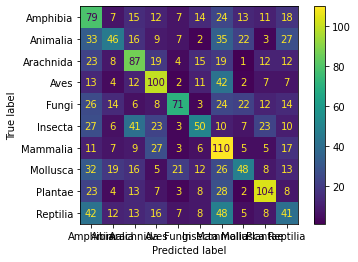

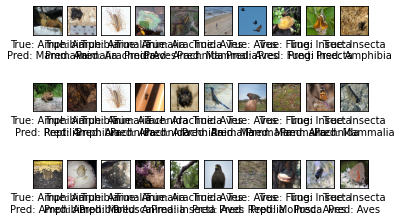

In [14]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras

from sklearn import metrics

import pandas as pd
import os
import cv2


import wandb
from wandb.keras import WandbCallback

#To let the gpu memory utilisiation grow as per requirement
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
#Invalid device or cannot modify virtual devices once initialized.
    pass

#Note: Wandb logging has been removed from the script for easier running
    

# Dataset loading function
def load_dataset_batch(DATAPATH, IMG_HEIGHT, IMG_WIDTH, batch_size = None): 
             
    img_data_array=[] 
    class_name=[] 

    for dir1 in np.sort(os.listdir(DATAPATH)): 
     if dir1[0] != ".": 
         ctr = 0 
         for file in np.sort(os.listdir(os.path.join(DATAPATH, dir1))): 
             ctr += 1 
             if batch_size == None:     
                 image_path= os.path.join(DATAPATH, dir1,  file) 
                 image= cv2.imread( image_path, cv2.COLOR_BGR2RGB) 
                 image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA) 
                 image=np.array(image) 
                 image = image.astype('float32') 
                 image /= 255  
                 img_data_array.append(image) 
                 class_name.append(dir1) 
             else: 
                 if ctr <= batch_size: 
                     image_path= os.path.join(DATAPATH, dir1,  file) 
                     image= cv2.imread( image_path, cv2.COLOR_BGR2RGB) 
                     image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA) 
                     image=np.array(image) 
                     image = image.astype('float32') 
                     image /= 255  
                     img_data_array.append(image) 
                     class_name.append(dir1) 
    return img_data_array, class_name 
          
#class names:
def class_names(DATAPATH):
   
    class_name=[]
    
    for dir1 in np.sort(os.listdir(DATAPATH)):
        class_name.append(dir1)
    return class_name


class_names = class_names("inaturalist_12K/test/")
target_dict = {k: v for v, k in enumerate(np.unique(class_names))} 
class_label_names_dict = {str(k): v for k, v in enumerate(np.unique(class_names))} 

# The dimensions of our input image
img_width,img_height = 128, 128

img_array, class_labels = load_dataset_batch("inaturalist_12K/test/", 128,128) 
img_array = np.array([img_array]).reshape(len(img_array), img_width, img_height,3)
class_labels_num = [target_dict[class_labels[i]] for i in range(len(class_labels))] 


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
            'inaturalist_12K/test/',
            target_size=(img_width,img_height),
            batch_size=32,
            class_mode='categorical',
            shuffle = False)
# Our target layer: we will visualize the filters from this layer.

#Model trained from scratch
source_model = keras.models.load_model("/content/drive/MyDrive/CS6910_CNN/BestModel/Image_recog5_dn_128_opt_sgd_dro_0.3_bs_32_fm_double_bnl_After_dpl_dense") #Load the best trained model
#Transfer learned model
#source_model = keras.models.load_model("./TrainedModel/Best_TransferlearntModel") #Load the best trained model

# See `model.summary()` for list of layer names, if you want to change this.
source_model.summary()
layer_dict = {layer.name:layer for layer in source_model.layers}
print(layer_dict)

test_generator2 = test_datagen.flow_from_directory(
            'inaturalist_12K/test/',
            target_size=(img_width,img_height),
            batch_size=32,
            class_mode='categorical',
            shuffle = True, seed=1234)
            
#Test loss and accuracy on the shuffled test dataset            
history = source_model.evaluate(test_generator2)


#Confusion Matrix
pred_labels = source_model.predict(test_generator)
pred_labels_num = np.argmax(pred_labels, axis = 1)
cm = metrics.confusion_matrix(test_generator.classes, np.argmax(pred_labels, axis = 1))
#metrics.ConfusionMatrixDisplay(cm, display_labels = [0,1,2,3,4,5,6,7,8,9]).plot() 
#With label names:
metrics.ConfusionMatrixDisplay(cm, display_labels = test_generator.class_indices).plot() 
plt.show()



#Sample image predictions
ROWS = 3 
COLUMNS = 10  
ix = 1 
for i in range(ROWS): 
    for j in range(COLUMNS): 
        # specify subplot and turn of axis 
        idx = np.random.choice(len(test_generator[4*j][0])) 
        img = test_generator[4*j][0][idx] 
        ax = plt.subplot(ROWS, COLUMNS, ix) 
        ax.set_xticks([]) 
        ax.set_yticks([]) 
        # plot filter channel in grayscale 
        plt.imshow(img) 
        plt.xlabel(
                    "True: " + class_label_names_dict[str(np.argmax(test_generator[4*j][1][idx]))] +"\n" + "Pred: " + 
                    class_label_names_dict[str(np.argmax(source_model.predict(img.reshape(1,128,128,3))))]
                   )     
        ix += 1 
plt.show()

Filter Visulaizations


Found 2000 images belonging to 10 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 64)      3136      
                                                                 
 activation (Activation)     (None, 125, 125, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 125, 125, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 128)       131200    
                                                                 
 activation_1

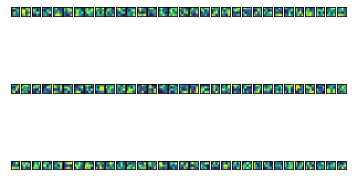

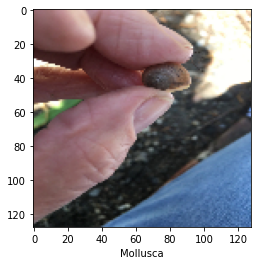

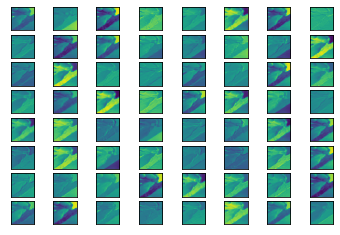

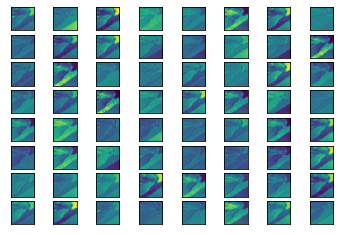

In [18]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras

import os

import wandb
from wandb.keras import WandbCallback


#To let the gpu memory utilisiation grow as per requirement
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
#Invalid device or cannot modify virtual devices once initialized.
    pass

def class_names(DATAPATH):
   
    class_name=[]
    
    for dir1 in np.sort(os.listdir(DATAPATH)):
        class_name.append(dir1)
    return class_name
    
class_names = class_names("inaturalist_12K/test/")
target_dict = {k: v for v, k in enumerate(np.unique(class_names))} 
class_label_names_dict = {str(k): v for k, v in enumerate(np.unique(class_names))} 
# The dimensions of our input image
img_width,img_height = 128, 128


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
            'inaturalist_12K/test',
            target_size=(img_width,img_height),
            batch_size=32,
            class_mode='categorical',
            shuffle = False)
# Our target layer: we will visualize the filters from this layer.

source_model = keras.models.load_model("/content/drive/MyDrive/CS6910_CNN/BestModel/Image_recog5_dn_128_opt_sgd_dro_0.3_bs_32_fm_double_bnl_After_dpl_dense") #Load the best trained model

# See `model.summary()` for list of layer names, if you want to change this.
source_model.summary()
layer_dict = {layer.name:layer for layer in source_model.layers}
print(layer_dict)
#Task: to  build a simple terminal user interface


#1st Convolutional layer:
layer_name = "conv2d" 
activation_layer_name = "activation"

layer = source_model.get_layer(name=layer_name)
activation_layer = source_model.get_layer(name=activation_layer_name)

feature_extractor = keras.Model(inputs=source_model.inputs, outputs=layer.output)
feature_extractor_activation = keras.Model(inputs=source_model.inputs, outputs=activation_layer.output)


filters, biases = layer.get_weights()


# normalize filter values to 0-1 so we can visualize them
filter_min, filter_max = filters.min(), filters.max()
filters = (filters - filter_min) / (filter_max - filter_min)


# plot first few filters
n_filters, ix = 32, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot( 3, n_filters, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j])
		ix += 1
# show the figure
plt.show()

#To get filters of all conv layers uncomment the following:
'''
i = 0 
for layer in model.layers: 
    if 'conv' not in layer.name: 
        continue 
    i += 1 
    globals()["filters"+ str(i)],globals()["biases"+str(i)] = layer.get_weights()
''' 

batch = np.random.choice(int(2000/32))
img_index = np.random.choice(32)    
img = test_generator[batch][0][img_index]
img = np.expand_dims(img, axis = 0)
img_true_label = test_generator[batch][1][img_index]

#plot the test image:
plt.figure()
plt.xlabel(class_label_names_dict[str(np.argmax(img_true_label))])
plt.imshow(img[0])
plt.show()



#Extract the feature maps and feature activation maps
feature_maps = feature_extractor(img) 
feature_maps_activation = feature_extractor_activation(img) 

#32 filters in the first layer:
ROWS = 8
COLUMNS = 8 
ix = 1
for _ in range(ROWS):
	for _ in range(COLUMNS):
		# specify subplot and turn of axis
		ax = plt.subplot(ROWS, COLUMNS, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[0, :, :, ix-1])
		ix += 1
# show the figure
plt.show() 

ROWS = 8
COLUMNS = 8 
ix = 1
for _ in range(ROWS):
	for _ in range(COLUMNS):
		# specify subplot and turn of axis
		ax = plt.subplot(ROWS, COLUMNS, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps_activation[0, :, :, ix-1])
		ix += 1
# show the figure
plt.show()

Found 2000 images belonging to 10 classes.


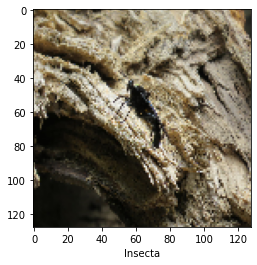

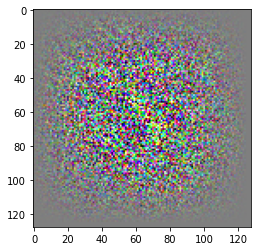

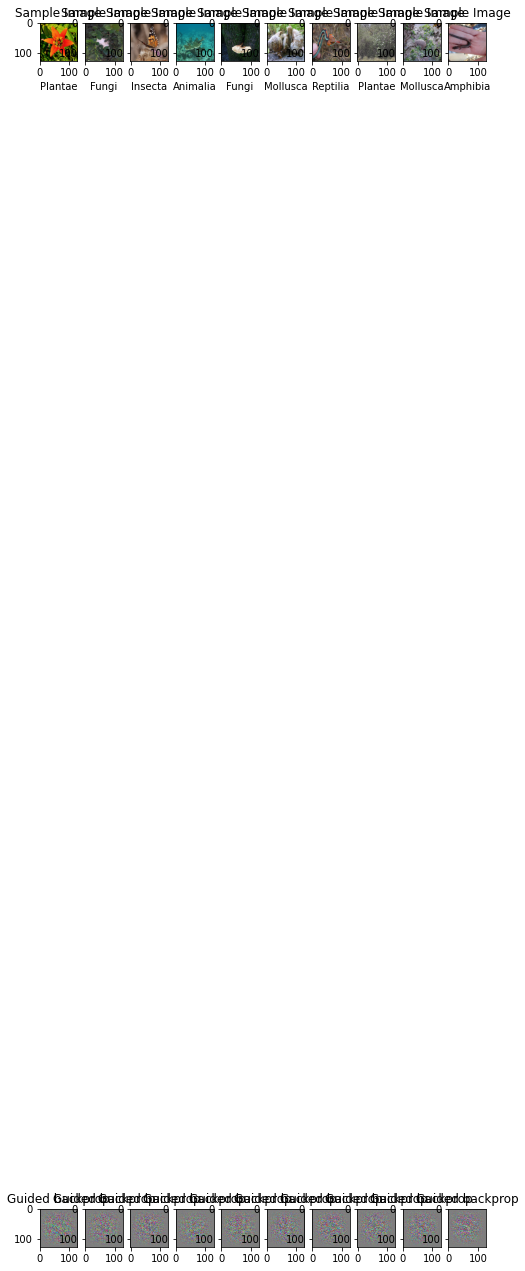

(<keras.engine.sequential.Sequential at 0x7f19eebebd90>,
 <keras.engine.functional.Functional at 0x7f19efab2a10>)

In [19]:
import os
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

import wandb
from wandb.keras import WandbCallback

#To let the gpu memory utilisiation grow as per requirement
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
#Invalid device or cannot modify virtual devices once initialized.
    pass

#Default image size:
IMG_SIZE = (128, 128)
DATAPATH = "inaturalist_12K/test"
MODELPATH = "/content/drive/MyDrive/CS6910_CNN/BestModel/Image_recog5_dn_128_opt_sgd_dro_0.3_bs_32_fm_double_bnl_After_dpl_dense"

#Functions to process images
def load_image(path, preprocess=True):
    """Load and rescale image."""
    img = image.load_img(path, target_size=IMG_SIZE)
    if preprocess:
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = img/255
        print
    return img

def class_names(DATAPATH):
   
    class_name=[]
    
    for dir1 in np.sort(os.listdir(DATAPATH)):
        class_name.append(dir1)
    return class_name
  
  
def load_sample_image_from_all_classes(DATAPATH, IMG_HEIGHT, IMG_WIDTH): 
             
    img_data_array=[] 
    class_name=[] 

    for dir1 in np.sort(os.listdir(DATAPATH)): 
        if dir1[0] != ".":
            img_file = random.choice( np.sort(os.listdir(os.path.join(DATAPATH, dir1))))
            image_path= os.path.join(DATAPATH, dir1,  img_file) 
            img1= cv2.imread( image_path, cv2.COLOR_BGR2RGB) 
            img1= cv2.resize(img1, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA) 
            img1=np.array(img1) 
            img1 = img.astype('float32')
            #img1 /= 255
            img_data_array.append(img1) 
            class_name.append(dir1) 
    return img_data_array, class_name 
         
 

def deprocess_image(img):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    img = img.copy()
    img -= img.mean()
    img /= (img.std() + K.epsilon())
    img *= 0.25

    # clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # convert to RGB array
    img *= 255
    if K.image_data_format() == 'channels_first':
        img = img.transpose((1, 2, 0))
    img = np.clip(img, 0, 255).astype('uint8')
    return img
 
#Custom gradient function for guided backpropagation. Consists of guided relu function and its gradient.        
@tf.custom_gradient
def guidedRelu(x):
  def grad(dy):
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad

# Guided backpropagation on multiple images:
#------------------------------------------#

def guided_backpropagation(MODELPATH, num_sample_images = 10):

    # loading the data and the model
    model = tf.keras.models.load_model(MODELPATH)


    gb_model = Model(
        inputs = [model.inputs],
        outputs = [model.get_layer("conv2d_4").output]
    )
        
    for layer in model.layers:
        if hasattr(layer, 'activation') and layer.activation==tf.keras.activations.relu:
            layer.activation = guidedRelu

    # plotting the images
    fig, ax = plt.subplots(2, num_sample_images, figsize=(2*4, num_sample_images*4))
    sample_imgs = tf.convert_to_tensor(test_generator[0][0][:num_sample_images], dtype=tf.float32)
    sample_img_labels = np.array([np.argmax(test_generator[0][1][i]) for i in range(num_sample_images)])
    
    for i in range(num_sample_images):

        with tf.GradientTape() as tape:
            input_img = tf.expand_dims(sample_imgs[i], 0)
            tape.watch(input_img)
            output = gb_model(input_img)[0]
        
        gradients = tape.gradient(output,input_img)[0]

        ax[0][i].set_title("Sample Image")
        ax[0][i].imshow(sample_imgs[i])
        ax[0][i].set_xlabel(class_label_names_dict[str(sample_img_labels[i])])
        ax[1][i].set_title("Guided backprop")
        ax[1][i].imshow(deprocess_image(np.array(gradients)))
        #ax[1][i].imshow(gradients)
    plt.show()

    return model, gb_model



#Execution:
#----------#

class_names = class_names("inaturalist_12K/test/")
target_dict = {k: v for v, k in enumerate(np.unique(class_names))} 
class_label_names_dict = {str(k): v for k, v in enumerate(np.unique(class_names))} 


#Test data generator alternative for loading images:
#--------------------------------------------------#
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
            'inaturalist_12K/test',
            target_size=IMG_SIZE,
            batch_size=32,
            class_mode='categorical',
            shuffle = True,
            seed = 1234)

batch = np.random.choice(int(2000/32))
img_index = np.random.choice(32)    
img = test_generator[batch][0][img_index]
img = np.expand_dims(img, axis = 0)
img_true_label = test_generator[batch][1][img_index]

#plot the test image:
plt.figure()
plt.xlabel(class_label_names_dict[str(np.argmax(img_true_label))])
plt.imshow(img[0])
plt.show()


#Guided backprop testing on a sample image:
model = tf.keras.models.load_model(MODELPATH)

gb_model = Model(
    inputs = [model.inputs],
    outputs = [model.get_layer("conv2d_4").output]
)

#List of layers 
layer_list = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]

#Replace the relu activation layer with the guided activation layer
for layer in layer_list:
  if layer.activation == tf.keras.activations.relu:
    layer.activation = guidedRelu

#Observing the gradient flow for a chosen sample image:
with tf.GradientTape() as tape:
  inputs = tf.cast(img, tf.float32)
  tape.watch(inputs)
  outputs = gb_model(inputs)


grads = tape.gradient(outputs,inputs)[0]

plt.imshow(deprocess_image(np.array(grads))) 


#Just to visualise the backpropagated gradients on multiple sample images:
guided_backpropagation(MODELPATH)